### This notebook's purpose is to get the CALCE data in a workable format (in a dataframe, cleaned, battery type labeled etc.)

### Goals: (Add to this)
1. Get files from CALCE website into dataframe(s)
2. Add label for every cycle which battery this data came from 
3. Find/Remove empty cells  (delete the whole row or should we do interpolation?) (Might not even have empty cells)


All CS2 cells underwent the same charging profile which was a standard constant current/constant voltage protocol with a constant current rate of 0.5C until the voltage reached 4.2V and then 4.2V was sustained until the charging current dropped to below 0.05A. Unless specified, the discharge cut off voltage for these batteries was 2.7V. All the CS2 cells were randomly numbered and named accordingly. Name 'CS2_n' was given for the nth numbered CS2 cell. 

#### Imports:

In [1]:
import scipy.io
import scipy.signal
import os 
import pandas as pd
import zipfile
import requests
import xlrd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import statistics as stats
from math import isclose
from sklearn import mixture

%matplotlib inline

#### Notes:
To import .mat files into python:  
import scipy.io   
mat = scipy.io.loadmat('file.mat')  

To unzip files: look at SEDS HW2 (not sure if we will use this)


#### CS2 data (in excel format*)  
Look at CS2 data first. From the website, CS2_'n' was given to the nth numbered CS2 cell (identifies unique cells from eachother). Each cell was cycled multiple times. Excel files are named using the testing dates.  **Were the same cells cycled on different dates or was the continuous cycling data split into multiple excel files?**   

*CS2_8 and CS2_21 are in .txt format because they were cycled using a different system.

Starting with CS2_33, in excel file format

In [2]:
data1 = pd.read_excel("data/CS2_33/CS2_33_10_04_10.xlsx", sheet_name= "Channel_1-006")
#it looks like all of these have the sheet name channel_1-006, not just this specific excel file? 
#would be nice to create a function to iterate over all the files in a given file and import them, store them in variable. 

In [3]:
data1['Cycle_Index'].max()
#this gives the number of cycles they ran

23

In [4]:
#we will need to clean the data so that dq/dv does not come back with weird data, ie we need to make sure the dq/dv isn't being 
# calculated between identical voltage values (because then dv = 0)
# (dq/dt)/(dv/dt)= dq/dv 
# (dq/dt) = current 


# calculate dv, find values close to 0, delete those rows, reindex, calculate dv again, 

New Column- To calculate dq/dv do discharge/charge capacity/ dv. calculate dv first. Ask robert whether to use discharge or charge capacity to calculate this. or do both and compare. Maybe ask user which capacity to use between discharge and charge - depends on system (i.e. Maccor) , which anode or cathode they are looking at etc. 

In [5]:
data1['dV'] = None 

In [6]:
data1.loc[2, ('Voltage(V)')]

3.4519877433776855

In [7]:
range(len(data1))

range(0, 10759)

In [8]:
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]


In [9]:
data1['dQ/dV'] = data1['Discharge_Capacity(Ah)']/data1['dV']

In [10]:
data1.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV
0,1,30.000116,2010-09-27 14:12:48,30.000117,1,1,0.000000,3.451826,0.000000,0.0,0.000000,0.0,-0.000032,0.0,0,0,0,None,NaN
1,2,60.015409,2010-09-27 14:13:18,60.015410,1,1,0.000000,3.451826,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0,NaN
2,3,90.030676,2010-09-27 14:13:48,90.030677,1,1,0.000000,3.451988,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0.000161886,0
3,4,120.014848,2010-09-27 14:14:18,120.014848,1,1,0.000000,3.451826,0.000000,0.0,0.000000,0.0,-0.000032,0.0,0,0,0,-0.000161886,-0
4,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.0,0.016314,0.0,0.001264,0.0,0,0,0,0.132995,0


In [11]:
data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=['dQ/dV'])

In [12]:
data1 = data1.reset_index(drop = True)

In [13]:
data1['dQ/dV'].mean()

113.589882961996

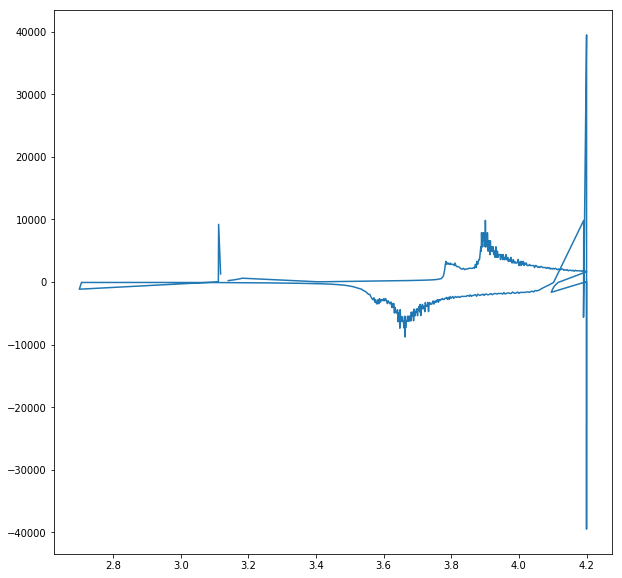

In [14]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['dQ/dV'])

In [15]:
for i in range(1,len(data1)):
    if isclose(data1.loc[i, ('dV')], 0, abs_tol = 10**-3):
        data1 = data1.drop(index = i)
#drop rows if dv is about 0, this will clean up the data points around V = 4.2V (since they are holding it at 4.2V for a while)
#have to recalculate the dv after this I think 

In [16]:
len(data1)

9758

In [17]:
data1 = data1.reset_index(drop = True)

In [18]:
#recalculating dv after dropping rows
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]


In [19]:
#recalculate dq/dv  
data1['dQ/dV'] = data1['Discharge_Capacity(Ah)']/data1['dV']

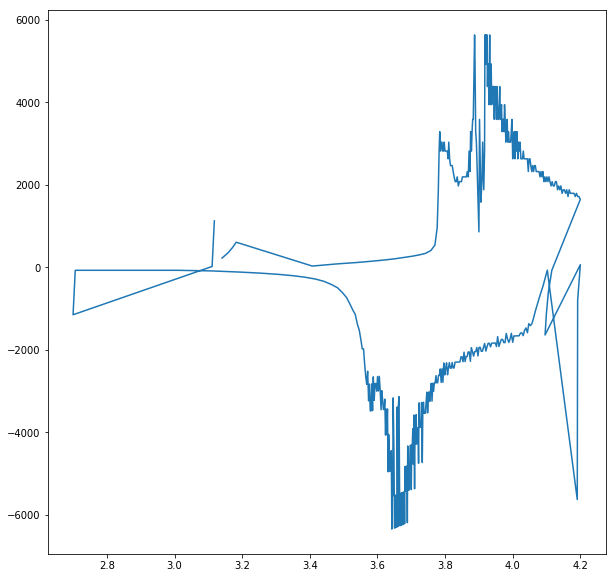

In [20]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['dQ/dV'])

In [21]:
#data1['dQ/dV-discharge cap'] = data1['Discharge_Capacity(Ah)']/data1['dV']

In [22]:
#data1['dQ/dV-charge cap'] = data1['Charge_Capacity(Ah)']/data1['dV']

Drop Rows With N/A or infinity in dq/dv-discharge cap row. First replace inf values for N/a values so can use dropna

In [23]:
#data1.replace([np.inf, -np.inf], np.nan)

In [24]:
data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=["dQ/dV"])

In [25]:
#data1.dropna(subset=['dQ/dV-discharge cap'], inplace= True)

In [26]:
data1['dQ/dV'].max()

41913.563841084666

In [27]:

data1.shape

(9758, 19)

In [28]:
data1.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg),dV,dQ/dV
0,3,90.030676,2010-09-27 14:13:48,90.030677,1,1,0.000000,3.451988,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0,0.000162,0.0
1,5,150.030659,2010-09-27 14:14:48,30.015332,2,1,0.550025,3.584821,0.004585,0.0,0.016314,0.0,0.001264,0.0,0,0,0,0.132833,0.0
2,6,180.045864,2010-09-27 14:15:18,60.030537,2,1,0.549845,3.625319,0.009170,0.0,0.032848,0.0,0.000972,0.0,0,0,0,0.040498,0.0
3,7,210.061288,2010-09-27 14:15:48,90.045961,2,1,0.549845,3.658041,0.013755,0.0,0.049547,0.0,0.000778,0.0,0,0,0,0.032722,0.0
4,8,240.076447,2010-09-27 14:16:18,120.061120,2,1,0.549845,3.685742,0.018340,0.0,0.066384,0.0,0.000680,0.0,0,0,0,0.027701,0.0


Reindex and calculate dV again 

### Filter Sav Golay

In [29]:
data1['dV'].describe()

count    9758.000000
mean        0.000053
std         0.027023
min        -0.100435
25%        -0.002754
50%        -0.001296
75%         0.002268
max         0.432679
Name: dV, dtype: float64

In [30]:
unfilt = pd.concat([data1['dQ/dV']])

In [31]:
unfiltar = unfilt.values
#converts into an array 

In [32]:
data1['filtered dq/dv'] = scipy.signal.savgol_filter(unfiltar, 19, 3)

In [33]:
data1.head(500);

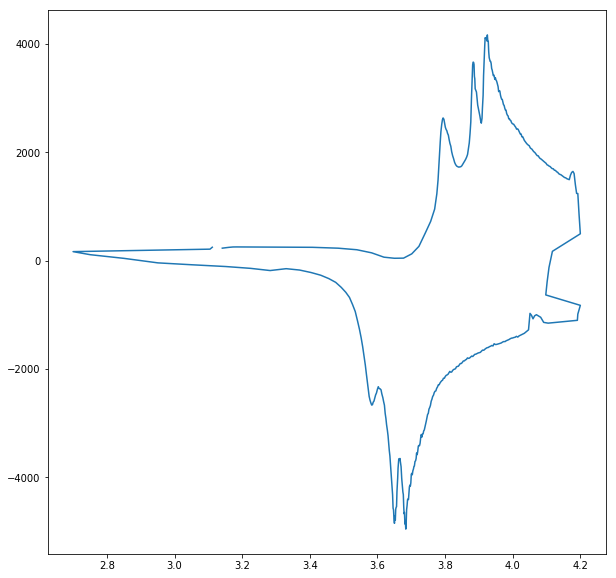

In [34]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 6:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['filtered dq/dv'])

In [35]:
df1.head()

,ACI_Phase_Angle(Deg),AC_Impedance(Ohm),Charge_Capacity(Ah),Charge_Energy(Wh),Current(A),Cycle_Index,Data_Point,Date_Time,Discharge_Capacity(Ah),Discharge_Energy(Wh),Internal_Resistance(Ohm),Is_FC_Data,Step_Index,Step_Time(s),Test_Time(s),Voltage(V),dQ/dV,dV,dV/dt(V/s),filtered dq/dv
2151,0.0,0.0,5.296682,21.022661,0.000000,6.0,2369.0,2010-09-28 11:35:25,5.305244,19.85983,0.094247,0.0,1.0,30.015294,76981.647121,3.141126,187.144097,0.028348,0.000583,229.220938
2152,0.0,0.0,5.296682,21.022661,0.000000,6.0,2370.0,2010-09-28 11:35:55,5.305244,19.85983,0.094247,0.0,1.0,60.030678,77011.662504,3.159431,289.823872,0.018305,0.000421,243.502198
2153,0.0,0.0,5.296682,21.022661,0.000000,6.0,2371.0,2010-09-28 11:36:25,5.305244,19.85983,0.094247,0.0,1.0,90.045891,77041.677718,3.172714,399.393464,0.013283,0.000292,251.051607
2154,0.0,0.0,5.296682,21.022661,0.000000,6.0,2372.0,2010-09-28 11:36:55,5.305244,19.85983,0.094247,0.0,1.0,120.014291,77071.646118,3.183244,503.844929,0.010530,0.000259,251.903285
2155,0.0,0.0,5.301266,21.038016,0.549845,6.0,2373.0,2010-09-28 11:37:25,5.305244,19.85983,0.094247,0.0,2.0,30.015314,77101.663946,3.407440,23.663375,0.224196,0.002624,244.924730


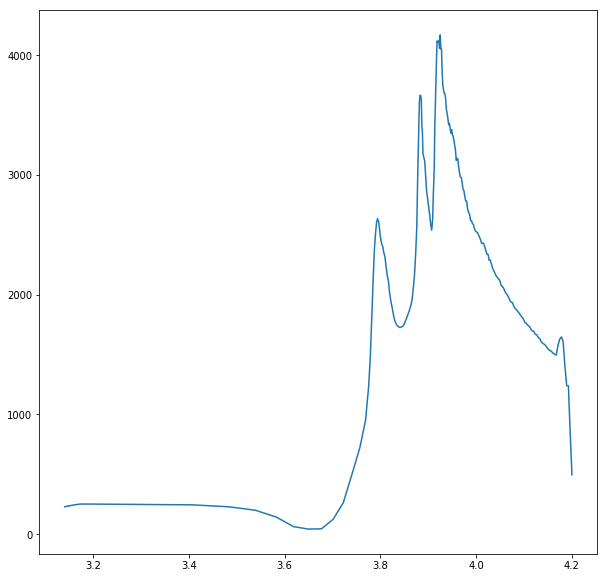

In [35]:
dftop = pd.DataFrame()
dftop = df1[df1['filtered dq/dv'] > 0].head(len(dftop.index)-6)
dftop = dftop.reset_index(drop=True)

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(dftop['Voltage(V)'], dftop['filtered dq/dv'])

In [36]:
sigx = pd.to_numeric(dftop['Voltage(V)'])
sigy = pd.to_numeric(dftop['filtered dq/dv'])

### PeakUtils

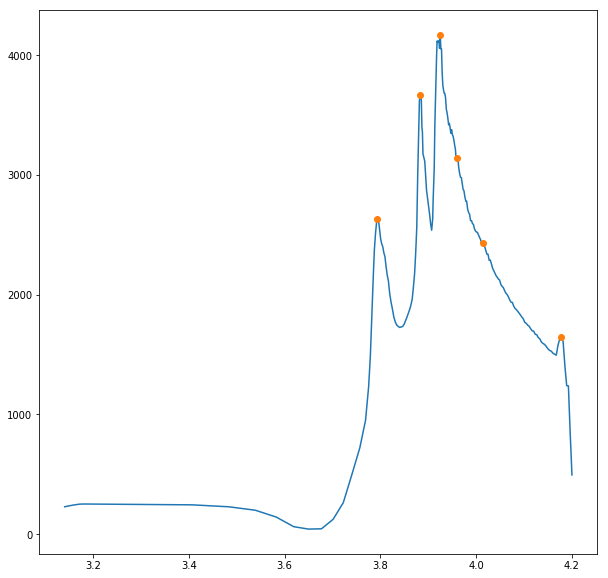

In [39]:
import peakutils
i = peakutils.indexes(sigy, thres=1000/max(sigy), min_dist=20)

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(dftop['Voltage(V)'], dftop['filtered dq/dv'])
plt.plot(dftop.loc[i, 'Voltage(V)'], dftop.loc[i, 'filtered dq/dv'], 'o')

Very Meh. I don't like that this one exclusively relies on amplitude. Gonna look for other packages.

### Octave

In [39]:
import oct2py

octave.eval("pkg load signal")
(peaks, i) = octave.findpeaks(sigy, 'DoubleSided', 'MinPeakHeight', 0.04, 'MinPeakDistance', 100, 'MinPeakWidth', 0)

OSError: Octave Executable not found, please add to path or set"OCTAVE_EXECUTABLE" environment variable

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(dftop['Voltage(V)'], dftop['filtered dq/dv'])
plt.plot(dftop.loc[i, 'Voltage(V)'], dftop.loc[i, 'filtered dq/dv'], 'o')

Octave is dumb. Not python based. Not worth pursuing

### Scipy find peaks

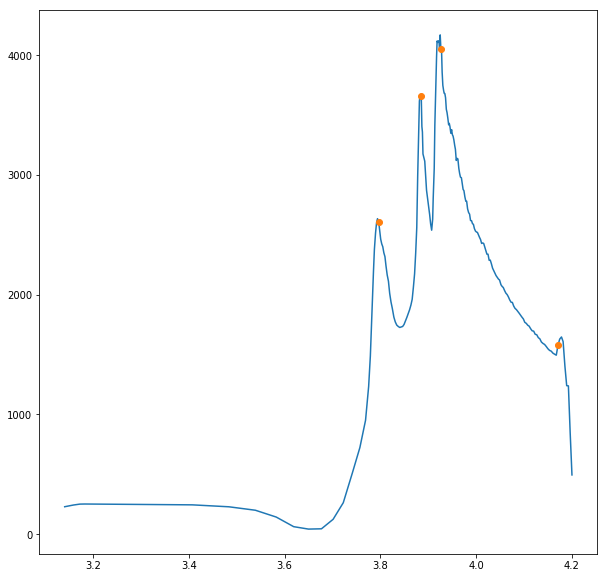

In [38]:
pwid = 8

i = scipy.signal.find_peaks_cwt(sigy, pwid+np.zeros(len(sigy)), min_snr=1)

fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
plt.plot(dftop['Voltage(V)'], dftop['filtered dq/dv'])
plt.plot(dftop.loc[i, 'Voltage(V)'], dftop.loc[i, 'filtered dq/dv'], 'o')

In [ ]:
#------------------------------------------------------------
# Learn the best-fit GMM models
#  Here we'll use GMM in the standard way: the fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GMM(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(5, 1.7))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-6, 6, 1000)
logprob, responsibilities = M_best.predict(x.reshape(-1,1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = M_best.predict_proba(x)
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()

From stack overflow https://stackoverflow.com/questions/43386493/what-is-the-correct-way-to-fit-a-gaussian-mixture-model-to-single-feature-data/43387278

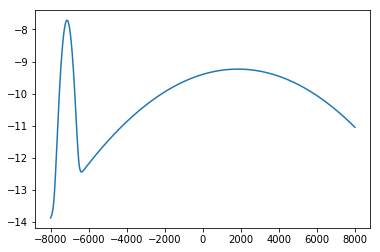

In [51]:
data = [0.0, 7000.0, 0.0, 7000.0, -400.0, 0.0, 7000.0, -400.0, -7400.0, 7000.0, -400.0, -7000.0, -7000.0, 0.0, 0.0, 0.0, -7000.0, 7000.0, 7000.0, 7000.0, 0.0, -7000.0, 6600.0, -7400.0, -400.0, 6600.0, -400.0, -400.0, 6600.0, 6600.0, 6600.0, 7000.0, 6600.0, -7000.0, 0.0, 0.0, -7000.0, -7400.0, 6600.0, -400.0, 7000.0, -7000.0, -7000.0, 0.0, 0.0, -400.0, -7000.0, -7000.0, 7000.0, 7000.0, 0.0, -7000.0, 0.0, 0.0, 6600.0, 6600.0, 6600.0, -7400.0, -400.0, -2000.0, -7000.0, -400.0, -7400.0, 7000.0, 0.0, -7000.0, -7000.0, 0.0, -400.0, -7400.0, -7400.0, 0.0, 0.0, 0.0, -400.0, -400.0, -400.0, -400.0, 6600.0, 0.0, -400.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -400.0, -400.0, 0.0, 0.0, -400.0, -400.0, 0.0, -400.0, 0.0, -400.0]

data = np.array(data).reshape(-1,1)
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(data)

x = np.array(np.linspace(-8000,8000,32000)).reshape(-1,1)
y = clf.score_samples(x)

plt.plot(x, y)

Attempt at making a samplable inverse_CDF from the dqdv data

In [91]:
sigy

0       229.220938
1       243.502198
2       251.051607
3       251.903285
4       244.924730
5       228.715599
6       199.977733
7       143.031422
8        62.760263
9        42.558968
10       44.967569
11      124.180506
12      262.717732
13      508.664966
14      723.245902
15      950.723259
16     1233.520522
17     1487.507525
18     1737.263786
19     1984.322875
20     2190.866943
21     2376.598690
22     2515.663578
23     2600.218946
24     2633.908652
25     2609.383600
26     2536.576275
27     2463.474190
28     2422.445109
29     2399.920702
          ...     
165    1768.870421
166    1759.525029
167    1744.456457
168    1736.825934
169    1714.668866
170    1697.901103
171    1694.875616
172    1668.915145
173    1665.107601
174    1641.027312
175    1630.852241
176    1604.446393
177    1592.022181
178    1584.090730
179    1567.422536
180    1547.935005
181    1534.404724
182    1527.870989
183    1511.791790
184    1502.519676
185    1494.400214
186    1577.

In [37]:
def inverse_CDF(sigy,edge):
    sigy = sigy.as_matrix()
    edge = edge.as_matrix()
    his = sigy[:-1]
    
    cdf_bins = np.cumsum(his * np.diff(edge))
    print(type(cdf_bins))
    cdf_bins = np.insert(cdf_bins, 0, 0)

    cdf_bins = cdf_bins/cdf_bins[-1]
    
    cdf = scipy.interpolate.interp1d(edge, cdf_bins)
    inv_cdf = scipy.interpolate.interp1d(cdf_bins, edge)

    return [cdf,inv_cdf]

<class 'numpy.ndarray'>


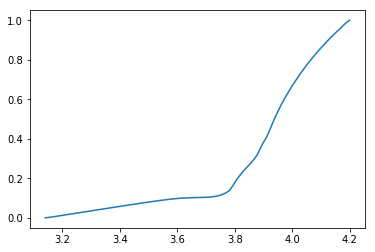

In [38]:
[cdf, inv_cdf] = inverse_CDF(sigy, sigx)
x = np.linspace(np.min(sigx.as_matrix()), np.max(sigx.as_matrix()), num=100)
plt.plot(x, cdf(x))

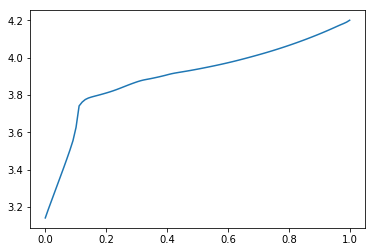

In [39]:
zero2one = np.linspace(0, .9999, num=100)
plt.plot(zero2one, inv_cdf(zero2one))

(array([ 203.,  211.,  239.,  200.,  240.,  270.,  214.,  226.,  219.,
         246.,  263.,  227.,  249.,  243.,  241.,  265.,  230.,  223.,
         247.,  279.,  268.,  222.,  239.,  239.,  241.,  243.,  251.,
         222.,  229.,  251.,  233.,  234.,  237.,  230.,  234.,  218.,
         212.,  211.,  167.,  186.,  193.,  176.,  148.,  153.,  132.,
          65.,   56.,   55.,   40.,   45.,   48.,   49.,   42.,  133.,
         108.,  261.,  324.,  478.,  681.,  851., 1566., 2444., 2343.,
        2092., 1879., 1607., 1665., 1695., 1816., 2557., 3276., 2860.,
        2626., 3828., 3667., 3384., 3175., 2975., 2679., 2563., 2467.,
        2381., 2290., 2206., 2152., 2085., 1902., 1931., 1856., 1790.,
        1687., 1647., 1617., 1571., 1415., 1508., 1407., 1528., 1503.,
        1020.]),
 array([3.14113242, 3.15172164, 3.16231085, 3.17290007, 3.18348929,
        3.1940785 , 3.20466772, 3.21525694, 3.22584615, 3.23643537,
        3.24702458, 3.2576138 , 3.26820302, 3.27879223, 3.28938145

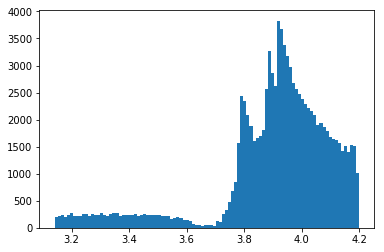

In [40]:
sample = inv_cdf(np.random.rand(100000))
plt.hist(sample, bins = 100)

## Actual Gaussian Mixture Model Stuff

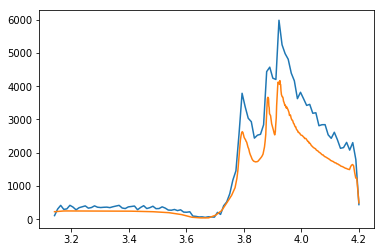

In [46]:
clf = mixture.GaussianMixture(n_components=100, covariance_type='full')
clf.fit(sample.reshape(-1,1))

x = np.linspace(np.min(sigx.as_matrix()), np.max(sigx.as_matrix()), num=100).reshape(-1,1)
y = clf.score_samples(x)

pdf = np.exp(y)

plt.plot(x, pdf*1600)
plt.plot(dftop['Voltage(V)'], dftop['filtered dq/dv'])


In [153]:
clf.predict_proba(x)

array([[1.13828283e-44, 1.81251587e-66, 1.00000000e+00, 2.39056503e-56],
       [2.56055077e-43, 4.88609770e-65, 1.00000000e+00, 6.70947948e-55],
       [5.50501611e-42, 1.27503736e-63, 1.00000000e+00, 1.80877459e-53],
       [1.13116457e-40, 3.22080256e-62, 1.00000000e+00, 4.68368220e-52],
       [2.22144205e-39, 7.87563772e-61, 1.00000000e+00, 1.16492440e-50],
       [4.16952116e-38, 1.86417977e-59, 1.00000000e+00, 2.78301418e-49],
       [7.47961720e-37, 4.27140039e-58, 1.00000000e+00, 6.38616959e-48],
       [1.28237357e-35, 9.47399624e-57, 1.00000000e+00, 1.40757916e-46],
       [2.10131781e-34, 2.03411998e-55, 1.00000000e+00, 2.97997459e-45],
       [3.29087147e-33, 4.22766296e-54, 1.00000000e+00, 6.05981893e-44],
       [4.92574695e-32, 8.50559266e-53, 1.00000000e+00, 1.18362488e-42],
       [7.04652944e-31, 1.65649159e-51, 1.00000000e+00, 2.22062833e-41],
       [9.63430611e-30, 3.12287302e-50, 1.00000000e+00, 4.00170453e-40],
       [1.25894747e-28, 5.69901561e-49, 1.00000000e

### Separate by Cycle

In [35]:
data1['Cycle_Index'].max()

23

In [36]:
gb = data1.groupby(by = ['Cycle_Index'])

In [37]:
print(gb)

In [38]:
for i in range(1, data1['Cycle_Index'].max() + 1):
    print(i)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
